In [2]:
import pandas as pd
import seaborn as sns
import numpy as np

In [3]:
def get_raw_data(name) -> pd.DataFrame:
    df = pd.read_csv(name, index_col = 0)
    return df

In [4]:
def get_intermediate_data(df) -> pd.DataFrame:
    data_types = ['int64','float64']
    convert_types = [np.int32, np.float32]
    for data_type, convert_type  in zip(data_types,convert_types):
        columns = df.dtypes[df.dtypes == data_type].index
        df[columns] = df[columns].astype(convert_type)
    return df

In [5]:
def get_primay_data(df) -> pd.DataFrame:
    "nothing happens here yet"
    return df

In [106]:
def get_features_data(df) -> pd.DataFrame:
    df['loans_income_ratio'] = df['age']/(df['NumberOfOpenCreditLinesAndLoans']\
                                                    + df['NumberRealEstateLoansOrLines']+0.1)
    return df

In [107]:
from sklearn.preprocessing import PolynomialFeatures

In [108]:
def prepare_ml_pipe(train_features) -> pd.DataFrame:
    num_columns = train_features.dtypes[train_features.dtypes != 'object'].index
    num_pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('polynomial',PolynomialFeatures())
])
    transformers = [('num_pipe', num_pipe, num_columns)]
    transformer = ColumnTransformer(transformers=transformers)
    ml_pipe = Pipeline([
    ('transformer', transformer),
    ('xgb', xgb.sklearn.XGBClassifier())
])
    return ml_pipe

In [109]:
df = get_raw_data('cs-training.csv')
df = get_intermediate_data(df)
df = get_features_data(df)

## Prepare Pipelines

In [111]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
import xgboost as xgb

In [112]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('SeriousDlqin2yrs',axis=1),
                                                    df['SeriousDlqin2yrs'],
                                                    test_size=0.3,
                                                    stratify=df['SeriousDlqin2yrs'],
                                                    random_state=78
                                                   )

In [113]:
param_grid = {
    'transformer__num_pipe__imputer__strategy': ['median','mean'],
    'transformer__num_pipe__polynomial': [None],
    'xgb__n_estimators': [100,200,500],
    'xgb__learning_rate':[0.1, 0.01, 0.001]
}

In [114]:
ml_pipe = prepare_ml_pipe(X_train)

In [115]:
gs = GridSearchCV(ml_pipe, param_grid, cv=5, return_train_score=False, n_jobs=-1, scoring = 'roc_auc')

In [116]:
gs.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('transformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num_pipe', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       ver...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'transformer__num_pipe__imputer__strategy': ['median', 'mean'], 'transformer__num_pipe__polynomial': [None], 'xgb__n_estimators': [100, 200, 500], 'xgb__learning_rate': [0.1, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='roc_auc', verbose=0)

In [117]:
gs.best_params_

{'transformer__num_pipe__imputer__strategy': 'mean',
 'transformer__num_pipe__polynomial': None,
 'xgb__learning_rate': 0.1,
 'xgb__n_estimators': 200}

In [118]:
gs.best_score_

0.8637355811617138

In [129]:
gs.best_estimator_.named_steps['xgb'].feature_importances_

array([0.1758646 , 0.06916851, 0.07211185, 0.19278881, 0.11405445,
       0.04709345, 0.09050772, 0.0397351 , 0.05813098, 0.02281089,
       0.11773363], dtype=float32)

In [55]:
columns = [column for column in df.columns.values if column not in ['NumberOfDependents ','MonthlyIncome']]

D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


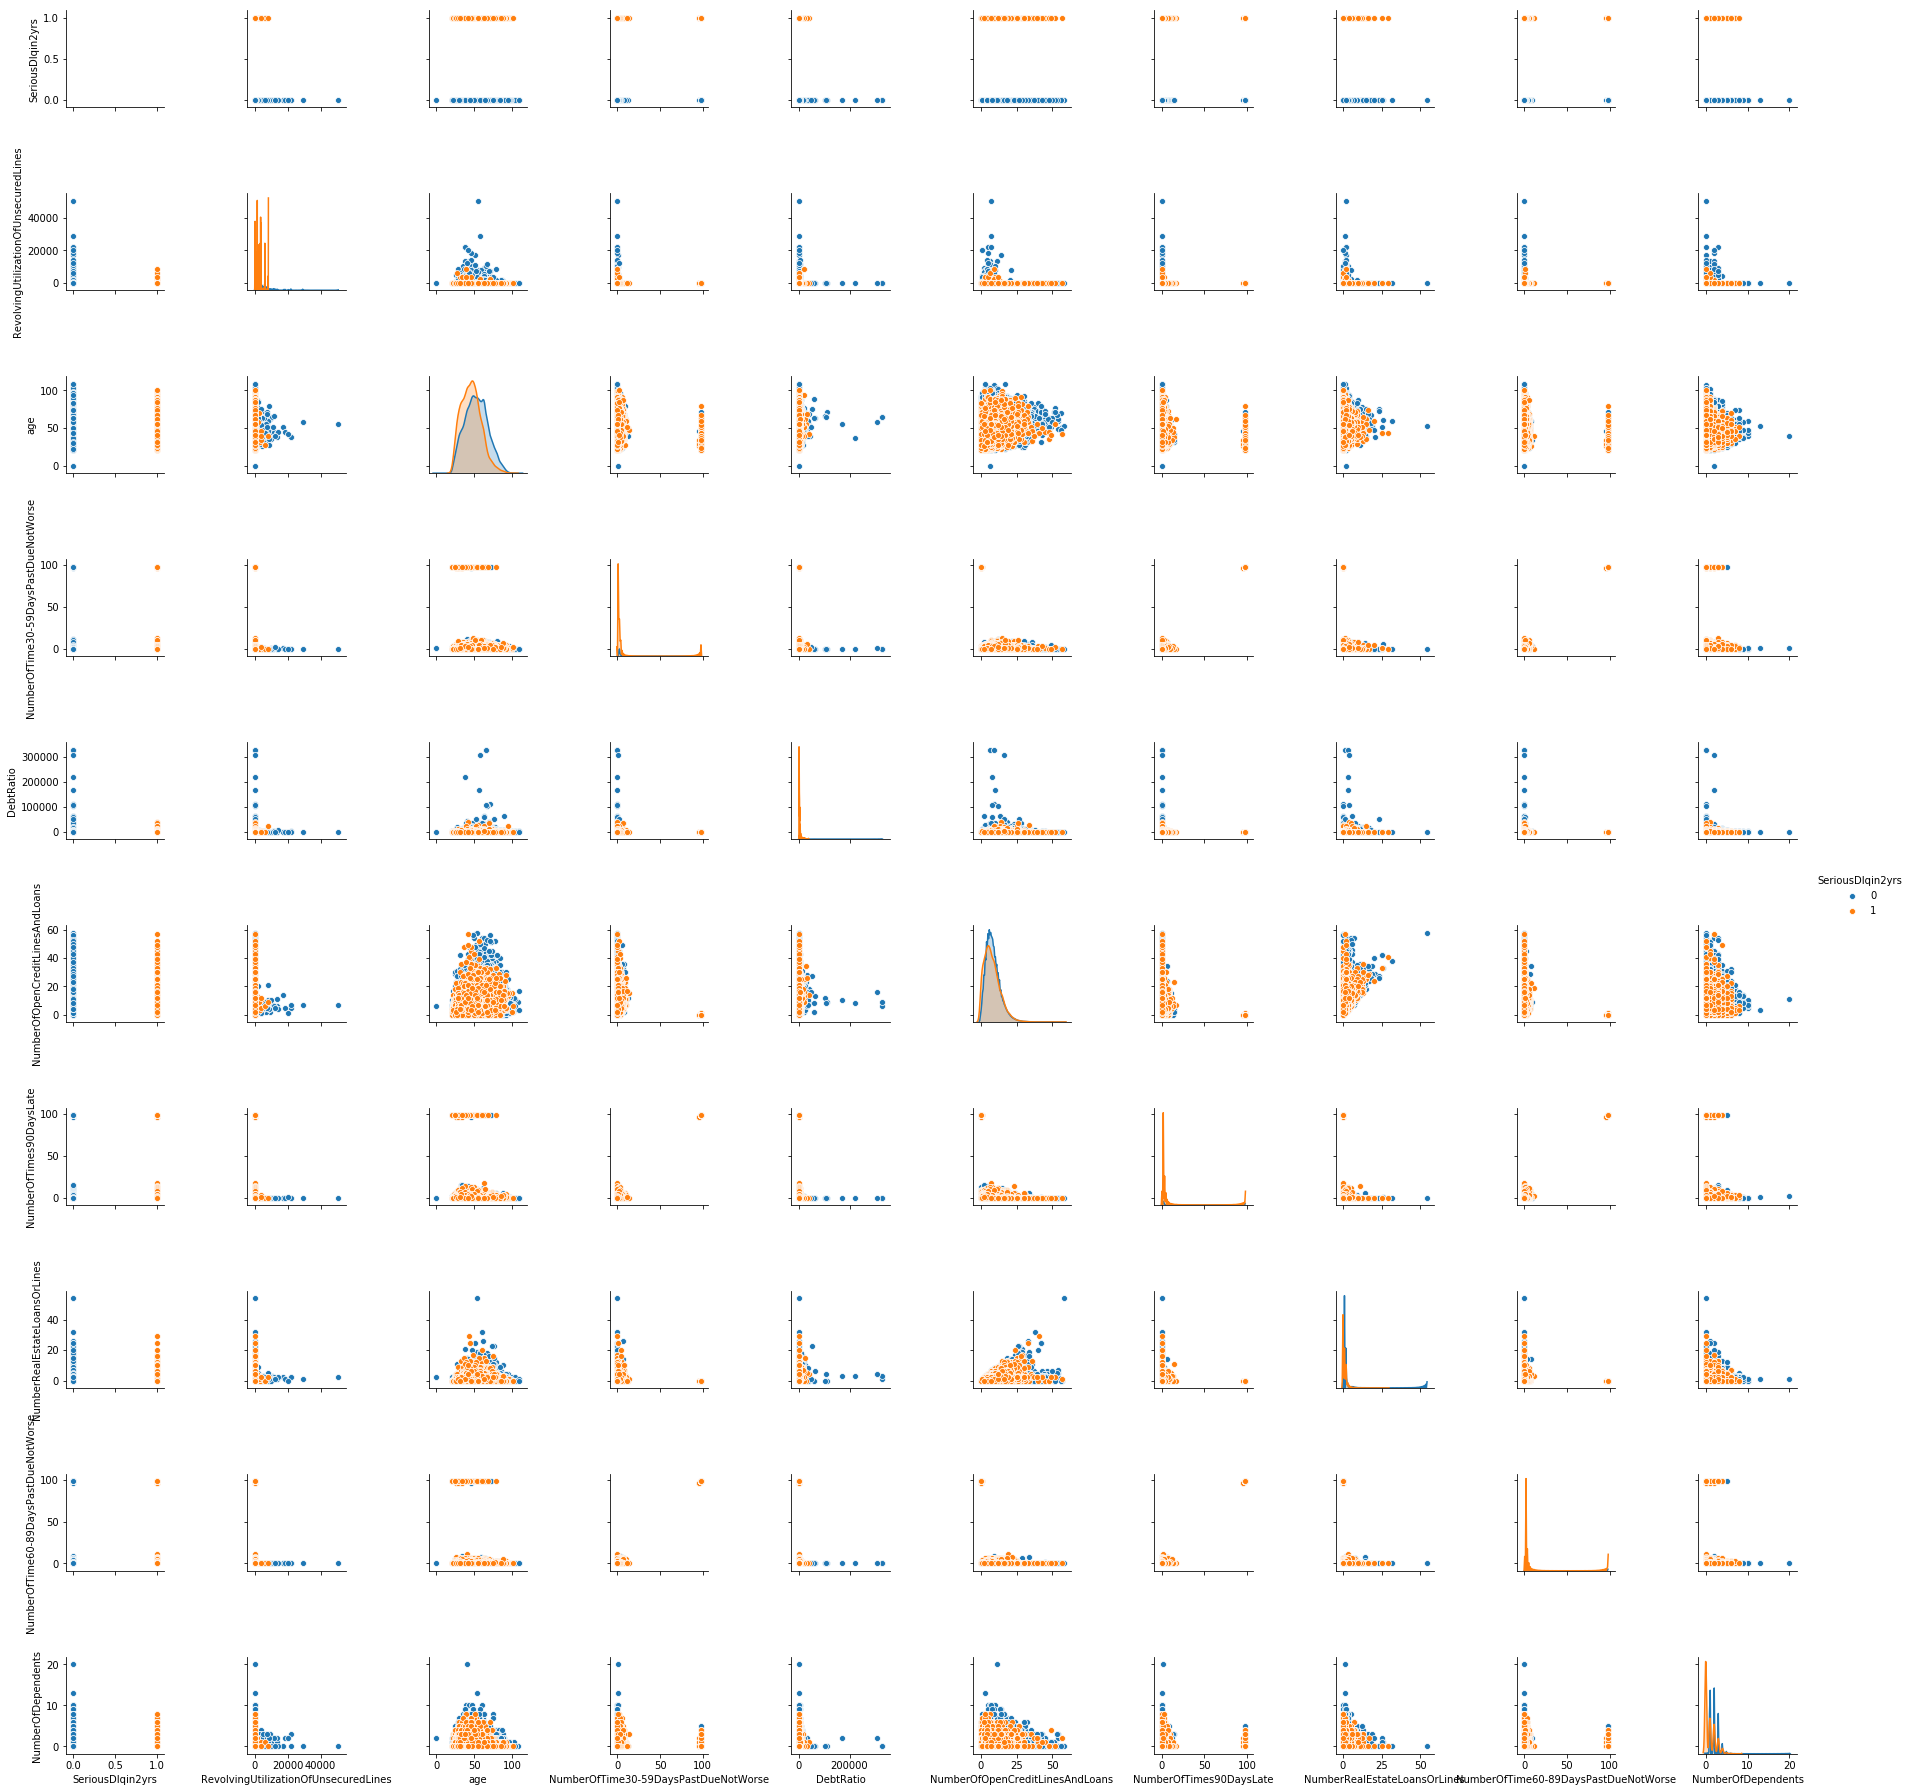

In [59]:
sns.pairplot(df[columns], hue='SeriousDlqin2yrs')